#### Imports and Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks  import EarlyStopping
from keras.models import Sequential
from keras.layers import Lambda, SimpleRNN, Dense

import IPython, IPython.display, os, datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ts_utils

mpl.rcParams['figure.figsize'] = (14, 4)
mpl.rcParams['axes.grid'] = True

2023-01-26 10:23:06.894712: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
# Read the data
df, df_scaled_trn, df_scaled_tst, scaler = ts_utils.load_file()
print("Training Data:")
display(df_scaled_trn)

input_slice  = slice(0,3)
label_slice  = slice(1,3)
window_len   = 3
ouput_len    = 3
batch_size   = 5

ouput_feat_len  = label_slice.stop - (label_slice.start or 0)
model_op_len    = ouput_feat_len * ouput_len

ds_trn = tf.data.Dataset.from_tensor_slices(df_scaled_trn[df_scaled_trn.columns[input_slice]])
ds_tst = tf.data.Dataset.from_tensor_slices(df_scaled_tst[df_scaled_trn.columns[input_slice]])
window_trn = ts_utils.window(ds_trn, window_len, ouput_len, label_slice, batch_size=batch_size, skip=1)
window_tst = ts_utils.window(ds_tst, window_len, ouput_len, label_slice, batch_size=batch_size, skip=1)

#print("\n\nSample Window to verify the window is working:\n")
#for w in window_trn.take(3):
#    print(f"{w[0].numpy().shape}\n{w[0].numpy()}\n=>:{w[1].numpy().shape}\n{w[1].numpy()} \n")


Training Data:


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),Day sin,Day cos,Year sin,Year cos
0,0.918199,-2.018473,-2.075600,-1.951683,1.102658,-1.315794,-1.483534,-0.788226,-1.485852,-1.488569,2.246640,-1.257984,-1.252731,0.214456,0.366058,1.366366,-0.049590,1.401955
1,0.932570,-2.116803,-2.174215,-2.096616,1.029922,-1.343873,-1.541361,-0.783947,-1.542786,-1.545690,2.356037,-1.232044,-1.252731,0.186889,0.707152,1.225091,-0.048581,1.401945
2,0.958917,-2.108510,-2.168345,-2.080512,1.048106,-1.342536,-1.534133,-0.786086,-1.535194,-1.538550,2.354292,-1.277439,-1.252731,-0.078439,1.000057,1.000355,-0.047571,1.401933
3,0.976881,-2.136943,-2.197695,-2.133215,0.993555,-1.350558,-1.553409,-0.779667,-1.554173,-1.559970,2.389927,-1.329318,-1.359684,0.757747,1.224811,0.707473,-0.046562,1.401921
4,1.033168,-2.205656,-2.270482,-2.225446,0.969309,-1.367941,-1.587141,-0.779667,-1.588333,-1.593290,2.479139,-1.134770,-1.145779,-0.195597,1.366097,0.366405,-0.045552,1.401908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56067,0.372099,0.968172,0.930989,0.772772,-0.861203,0.859638,0.687395,0.765285,0.677648,0.677237,-0.821697,0.551316,0.445669,-1.621823,-0.707116,-1.224304,0.811018,-1.136631
56068,0.321800,1.040439,1.007298,0.693717,-1.132749,0.962593,0.583788,1.024204,0.571371,0.574897,-0.891223,-0.823493,-0.546847,-0.857195,-1.000021,-0.999567,0.810227,-1.137265
56069,0.254736,1.233546,1.204528,0.661510,-1.517642,1.255414,0.542827,1.529202,0.533415,0.534437,-1.069895,-0.992101,-0.940431,-0.356402,-1.224775,-0.706686,0.809435,-1.137897
56070,0.206832,1.189712,1.164613,0.657118,-1.452180,1.187223,0.535599,1.424350,0.529619,0.529677,-1.044478,-0.881857,-0.940431,0.264994,-1.366061,-0.365618,0.808642,-1.138529


In [15]:
# yh: [batch, time, features length]
def inv_transform(yh, scaler, label_slice):
    yy=np.zeros([yh.shape[0], yh.shape[1], scaler.n_features_in_])
    yy[:, :, label_slice] = yh[0]
    ys = []
    for i in range(yh.shape[0]):
        yi = scaler.inverse_transform(yy[i])
        ys.append(yi[:, label_slice])
    return np.stack(ys)
    
#inv_transform(yh, scaler, label_slice)

def predict(model, window_trn, n=1):
    for w in window_trn.take(n):
        x = w[0]
        yh = model.predict(x)
        print(x.shape, x, "\n\n", yh, yh.shape)


In [103]:
def compile_fit(model, window_trn, window_tst= None, opt=None, patience=3, epochs=1):
    early_stop = EarlyStopping(monitor='val_loss', patience=patience, mode='min')

    loss = tf.keras.losses.MeanSquaredError()
    opt  = opt or tf.keras.optimizers.Adam()
    mets = [tf.keras.metrics.MeanAbsoluteError()]

    ##=> Other options you can try
    #learning_rate = 1e-6
    #opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    #opt = tf.keras.optimizers.SGD()
    #loss=tf.keras.losses.Huber()

    model.compile(loss= loss, optimizer= opt, metrics=mets)

    history = []
    if (window_trn is not None):
        history = model.fit(window_trn, epochs=epochs, validation_data=window_tst, callbacks=[early_stop])

    return history

# This commonLayer, a layer that is common to all models

def getCommonLayer(ouput_len, ouput_feat_len):
    op_len = ouput_len * ouput_feat_len;
    commonLayer = [
        # Shape => [batch, 1, out_len * #features]
        tf.keras.layers.Dense( op_len, kernel_initializer=tf.initializers.zeros()),
        # Shape => [batch, out_steps, features]
        tf.keras.layers.Reshape([ouput_len, ouput_feat_len])
    ]
    return commonLayer

performance = {}
models = []

In [108]:

srnn_model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(40)]
    + getCommonLayer(ouput_len, ouput_feat_len)
    , name="SimpleRNN")

models.append(srnn_model)
model = srnn_model
for opt in "sgd adam".split():
    history = compile_fit(model, window_trn, window_tst, epochs=5, opt=opt )
    performance[model.name + f":{opt}"] = ts_utils.eval_performance(model, window_trn, window_tst)


Epoch 1/5
11214/11214 [==============================] - 18s 2ms/step - loss: 0.0672 - mean_absolute_error: 0.1853 - val_loss: 0.1181 - val_mean_absolute_error: 0.2656
Epoch 2/5
11214/11214 [==============================] - 17s 2ms/step - loss: 0.0548 - mean_absolute_error: 0.1685 - val_loss: 0.1228 - val_mean_absolute_error: 0.2695
Epoch 3/5
11214/11214 [==============================] - 17s 1ms/step - loss: 0.0535 - mean_absolute_error: 0.1663 - val_loss: 0.1268 - val_mean_absolute_error: 0.2736
Epoch 4/5
2803/2803 [==============================] - 3s 1ms/step - loss: 0.1294 - mean_absolute_error: 0.2765
Epoch 1/5
11214/11214 [==============================] - 18s 2ms/step - loss: 0.0610 - mean_absolute_error: 0.1817 - val_loss: 0.1381 - val_mean_absolute_error: 0.2862
Epoch 2/5
11214/11214 [==============================] - 17s 1ms/step - loss: 0.0594 - mean_absolute_error: 0.1783 - val_loss: 0.1425 - val_mean_absolute_error: 0.2909
Epoch 3/5
11214/11214 [=========================

In [109]:
# Linear Model
linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :])
    ] + getCommonLayer(ouput_len, ouput_feat_len),
    name = "Linear"
)
models.append(linear_model)

In [110]:
# Add a Dense Layer

dlinear_model = tf.keras.Sequential([
        # Take the last time-step.
        # Shape [batch, time, features] => [batch, 1, features]
        tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
        tf.keras.layers.Dense(512, activation='relu')
    ] +  getCommonLayer(ouput_len, ouput_feat_len),
    name = "DenseLinear"
)

models.append(dlinear_model)

In [111]:
# CNN
CONV_WIDTH = 3
conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    ] + getCommonLayer(ouput_len, ouput_feat_len),
    name = "Conv"
)
models.append(conv_model)

In [112]:
# LSTM

lstm_model = tf.keras.Sequential([
        # Shape [batch, time, features] => [batch, lstm_units].
        # Adding more `lstm_units` just overfits more quickly.

        tf.keras.layers.LSTM(32, return_sequences=False)
    ]+ getCommonLayer(ouput_len, ouput_feat_len),
    name = "LSTM"
)
models.append(lstm_model)


Epoch 1/5
11214/11214 [==============================] - 11s 983us/step - loss: 0.1364 - mean_absolute_error: 0.2540 - val_loss: 0.0972 - val_mean_absolute_error: 0.2297
Epoch 2/5
11214/11214 [==============================] - 12s 1ms/step - loss: 0.0880 - mean_absolute_error: 0.2168 - val_loss: 0.0972 - val_mean_absolute_error: 0.2298
Epoch 3/5
11214/11214 [==============================] - 13s 1ms/step - loss: 0.0880 - mean_absolute_error: 0.2168 - val_loss: 0.0972 - val_mean_absolute_error: 0.2298
Epoch 4/5
2803/2803 [==============================] - 2s 746us/step - loss: 0.0972 - mean_absolute_error: 0.2297
Epoch 1/5
11214/11214 [==============================] - 13s 1ms/step - loss: 0.0936 - mean_absolute_error: 0.2276 - val_loss: 0.1656 - val_mean_absolute_error: 0.3079
Epoch 2/5
11214/11214 [==============================] - 12s 1ms/step - loss: 0.0882 - mean_absolute_error: 0.2212 - val_loss: 0.1521 - val_mean_absolute_error: 0.2952
Epoch 3/5
11214/11214 [=====================

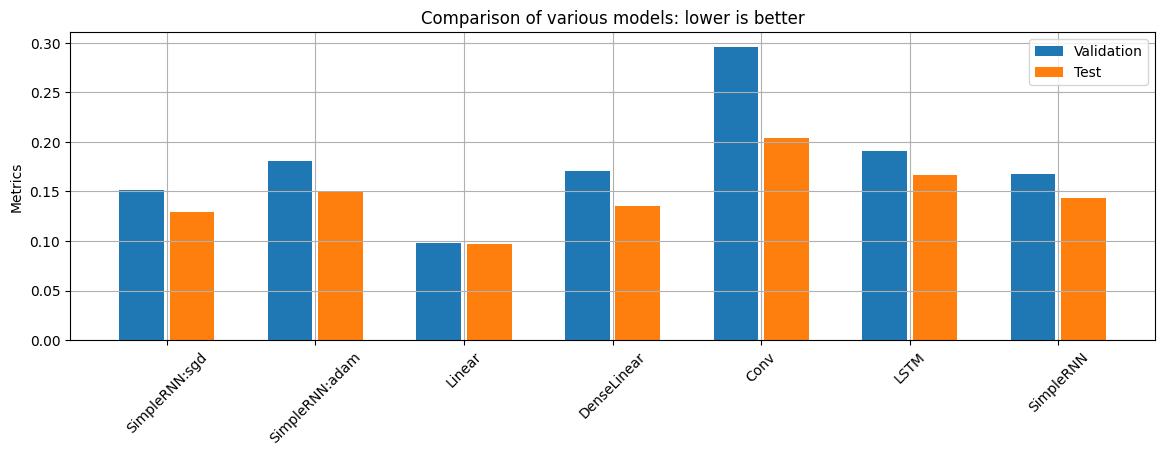

In [113]:
for model in models:
    history = compile_fit(model, window_trn, window_tst, epochs=5 )
    performance[model.name] = ts_utils.eval_performance(model, window_trn, window_tst)

# Plot graphs
performance = ts_utils.plot_performance([], window_trn, window_tst, performance=performance)

In [100]:
for w in window_trn:
    d, y = w
    yh = linear_model.predict(d)
    #print( "=>\n\n", l[0], l[1], d.shape, l.shape)
    break;

1/1 [==============================] - 0s 69ms/step


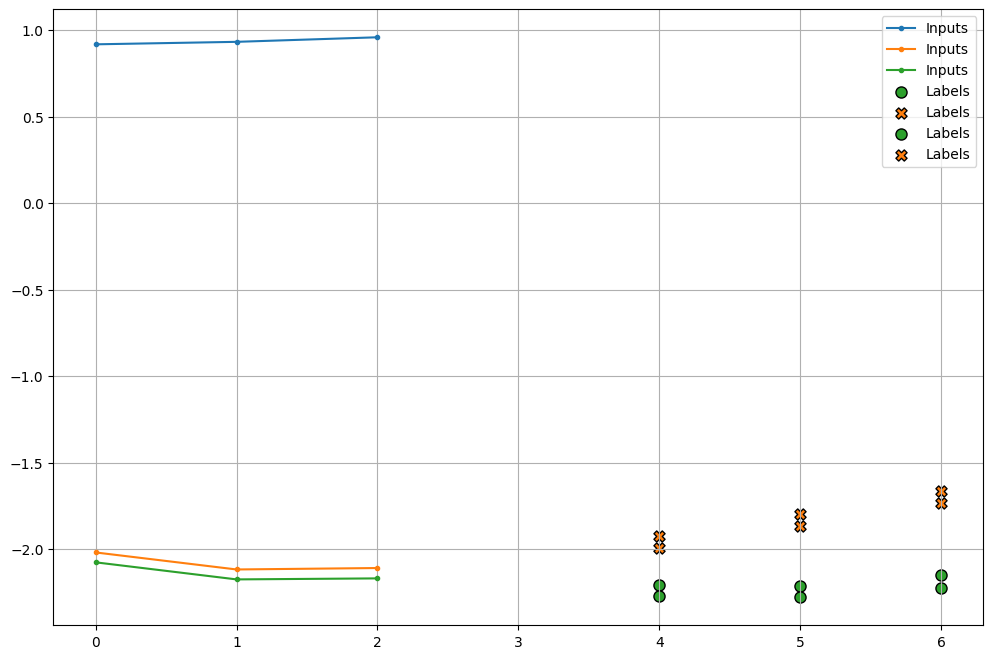

In [101]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

plt.figure(figsize=(12, 8))
max_n = 3
skip  = 1

for i in range(max_n):
    di, yi, yhi = d[i], y[i], yh[i]
    #plt.subplot(max_n, 1, i+1)
    #plt.ylim (-3,3)

    #mm = MinMaxScaler()
    #di = mm.fit_transform(di)

    for j in range(di.shape[1]):
        pass
        plt.plot(range(di.shape[0]), di[:, j], marker='.', label = "Inputs")

    for j in range(yi.shape[1]):
        xx = range( skip+di.shape[0], skip+di.shape[0]+yi.shape[1]+1)
        yy = yi[:,j]
        hy = yhi[:,j]
        plt.scatter( xx, yy, edgecolors='k', marker='o', label='Labels', c='#2ca02c', s=64)
        plt.scatter( xx, hy, edgecolors='k', marker='X', label='Labels', c='#ff7f0e', s=64)

    break;

plt.legend()